# Vehicle Detection
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

This project implements a software pipeline to detect vehicles in a video.  

The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import importlib
import numpy as np
from sklearn import svm
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from tqdm import tqdm
import time
import glob
import itertools
import math

%matplotlib inline

np.random.seed(12061979) # make random number generation repeatable

## Image Plotting

In [6]:
def plot_images_grid(images, labels=[]):
    grid_cols = 8 if len(images) >= 16 else 4 if len(images) >= 8 else 2 if len(images) >=2 else 1
    
    grid_rows = math.ceil(len(images)/float(grid_cols))
    fig_height_inches = math.ceil((16/float(grid_cols))*grid_rows)
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(16, fig_height_inches))
    fig.subplots_adjust(wspace=0.001, hspace=0.2)
    
    for ax, image, label in itertools.zip_longest(axes.ravel(), images, labels):
        if image is not None:
            ax.imshow(image)
            if label is not None:
                ax.set_title(label)
        ax.axis('off')


## Load Training Data Set
Data set images are loaded into memory in order to speed up feature extraction necessary for
e.g. hog parameter exploration.

In [7]:
vehicle_img_files = glob.glob('training_dataset/vehicles/**/*.png')
nonvehicle_img_files = glob.glob('training_dataset/non-vehicles/**/*.png')
print("vehicles: " + str(len(vehicle_img_files)), ", non vehicles: " + str(len(nonvehicle_img_files)))

def load_img(file):
    return mpimg.imread(file)

vehicle_imgs = [load_img(file) for file in tqdm(vehicle_img_files)]
nonvehicle_imgs = [load_img(file) for file in tqdm(nonvehicle_img_files)]

vehicles: 8792 , non vehicles: 8968


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:09<00:00, 983.23it/s]


## Vehicle Images from Training Data Set

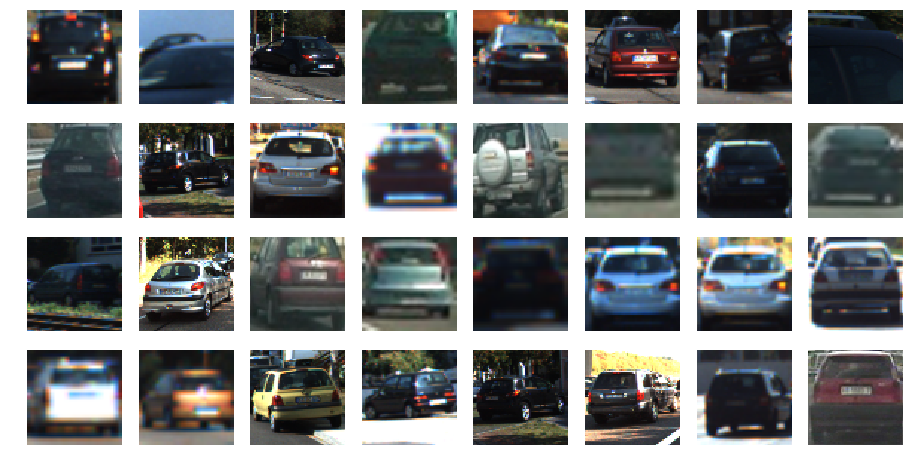

In [8]:
plot_images_grid([vehicle_imgs[i] for i in np.random.randint(0,len(vehicle_imgs),(32))])

## Non Vehicle Images from Training Data Set

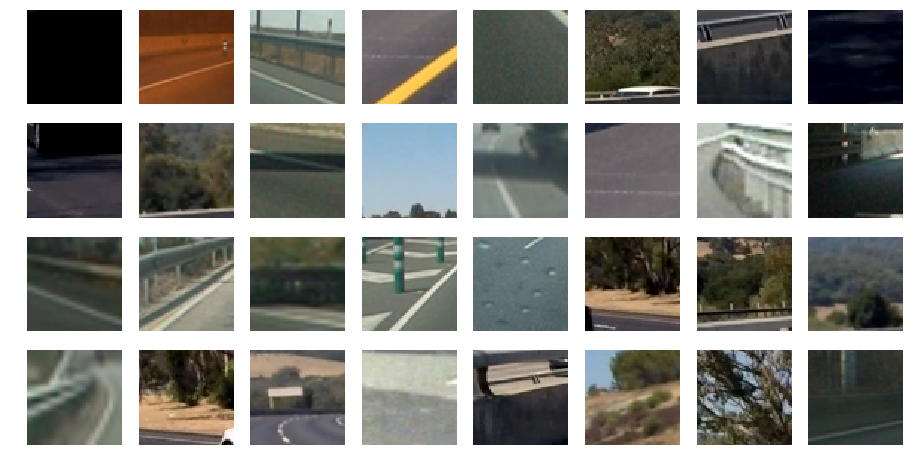

In [9]:
plot_images_grid([nonvehicle_imgs[i] for i in np.random.randint(0,len(nonvehicle_imgs),(32))])

## HOG Feature Extraction

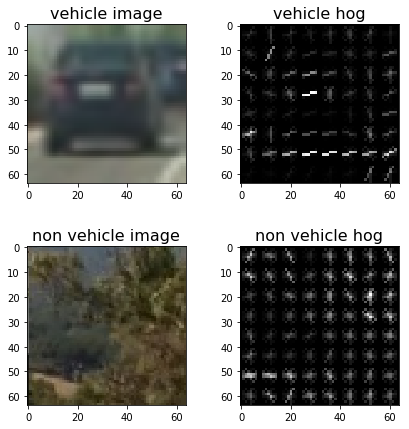

In [10]:
def hog_features(img, orientation, pixels_per_cell, cells_per_block, visualise):
    features, hog_image = hog(
        img, 
        orientations=orientation, 
        pixels_per_cell=(pixels_per_cell, pixels_per_cell),
        cells_per_block=(cells_per_block, cells_per_block), 
        transform_sqrt=False, 
        visualise=visualise, 
        feature_vector=True)
    return features, hog_image

# TODO: Change code
# TODO why '2' in third dimension of array?
vehicle_img = vehicle_imgs[0]
_, vehicle_hog = hog_features(vehicle_img[:,:,2], orientation=9, pixels_per_cell=8, 
                              cells_per_block=8, visualise=True)

nonvehicle_img = nonvehicle_imgs[1]
_, nonvehicle_hog = hog_features(nonvehicle_img[:,:,2], orientation=9, pixels_per_cell=8, 
                                 cells_per_block=8, visualise=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(vehicle_img)
ax1.set_title('vehicle image', fontsize=16)
ax2.imshow(vehicle_hog, cmap='gray')
ax2.set_title('vehicle hog', fontsize=16)
ax3.imshow(nonvehicle_img)
ax3.set_title('non vehicle image', fontsize=16)
ax4.imshow(nonvehicle_hog, cmap='gray')
ax4.set_title('non vehicle hog', fontsize=16)


## Feature Extraction for Training Data Set

In [11]:
class FeatureExtractionParams(object):
    def __init__(self, hog_color_space, hog_orientation, hog_pixels_per_cell, hog_cells_per_block, hog_channels):
        self.hog_color_space = hog_color_space 
        self.hog_orientation = hog_orientation
        self.hog_pixels_per_cell = hog_pixels_per_cell
        self.hog_cells_per_block = hog_cells_per_block
        self.hog_channels=hog_channels
        
    def __str__(self):
        return ("FeatureExtractionParams[orientation=" + str(self.hog_orientation) + 
            ", color space=" + self.hog_color_space +
            ", channels=" + str(self.hog_channels) +
            ", pixels per cell=" + str(self.hog_pixels_per_cell) + 
            ", cells per block=" + str(self.hog_cells_per_block) + 
            "]")


In [24]:
def features_for_image(img, params: FeatureExtractionParams):
    features = []
    color_space = params.hog_color_space
    if color_space != 'RGB':
        if color_space == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    for channel in params.hog_channels:
        channel_features = hog(
            img[:,:,channel], 
            orientations=params.hog_orientation, 
            pixels_per_cell=(params.hog_pixels_per_cell, params.hog_pixels_per_cell),
            cells_per_block=(params.hog_cells_per_block, params.hog_cells_per_block), 
            transform_sqrt=False, 
            visualise=False, 
            feature_vector=True)
        features.append(channel_features)
    
    return np.ravel(features)

In [29]:
# Duplicated and adapted from udacity lesson code
def features_for_image_list(imgs, params: FeatureExtractionParams):
    features_list = []
    for img in imgs:
        features_list.append(features_for_image(img, params))
    return features_list

In [26]:
def build_dataset(params: FeatureExtractionParams):
    vehicles_features = features_for_image_list(vehicle_imgs, params)
    nonvehicles_features = features_for_image_list(nonvehicle_imgs, params)

    X = np.vstack((vehicles_features, nonvehicles_features)).astype(np.float64)  
    y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(nonvehicles_features))))
    
    return X, y

## Parameter Exploration for SVM Training

In [27]:
def train_svm(X_train, y_train, X_test, y_test):
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    return svc, svc.score(X_test, y_test)
    

In [16]:
def explore_feature_extraction_params(params_list):
    # TODO improve: use pandas data frame to add results and then sort by svm accuracy
    rand_state = 33
    for params in params_list:
        t_start = time.time()
        X, y = build_dataset(params)
        t_feature_extraction = time.time() - t_start

        # split into train and test set
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=rand_state)

        t_train_start = time.time()
        _, score = train_svm(X_train, y_train, X_test, y_test)
        t_training = time.time() - t_train_start

        print("score=" + "{0:.2f}".format(score) + " for " + parms +
             " in " + "{0:.1f}".format(t_feature_extraction) + " secs feature extraction and " + 
             "{0:.1f}".format(t_training) + " secs training")

explore_feature_extraction_params(
    [
        """
        FeatureExtractionParams(
            hog_color_space = 'HSV',
            hog_orientation = 9,
            hog_pixels_per_cell = 8,
            hog_cells_per_block = 2,
            hog_channels=[2]),
        FeatureExtractionParams(
            hog_color_space = 'HSV',
            hog_orientation = 9,
            hog_pixels_per_cell = 8,
            hog_cells_per_block = 2,
            hog_channels=[0,1,2]),
        FeatureExtractionParams(
            hog_color_space = 'HLS',
            hog_orientation = 9,
            hog_pixels_per_cell = 8,
            hog_cells_per_block = 2,
            hog_channels=[2]),
        FeatureExtractionParams(
            hog_color_space = 'HLS',
            hog_orientation = 9,
            hog_pixels_per_cell = 8,
            hog_cells_per_block = 2,
            hog_channels=[0,1,2]),
        FeatureExtractionParams(
            hog_color_space = 'YUV',
            hog_orientation = 9,
            hog_pixels_per_cell = 8,
            hog_cells_per_block = 2,
            hog_channels=[0]),
        FeatureExtractionParams(
            hog_color_space = 'YUV',
            hog_orientation = 9,
            hog_pixels_per_cell = 8,
            hog_cells_per_block = 2,
            hog_channels=[0,1,2]),
        """
        FeatureExtractionParams(hog_color_space = 'YCrCb,
            hog_orientation = 9,
            hog_pixels_per_cell = 8,
            hog_cells_per_block = 2,
            hog_channels=[0,1,2])
    ])

SyntaxError: invalid syntax (<ipython-input-16-fa93ea41944e>, line 61)

|  No. |  Accuracy | Orientations | Color Space  | Channels  | Pixels per Cell  | Cells per Block | Time Feature Extraction | Time Training |
|---|---|---|---|---|---|---|
|  1 |  0.96 | 9  | HSV  |  2 | 8  | 2  | 22.5 | 5.2 |
|  2 |  0.98 | 9  | HSV  |  0,1,2 | 8  | 2  | 131.7 | 9 |
|  3 |  0.91 | 9  | HLS  |  2 | 8  | 2  | 39.6 | 7.2 |
|  4 |  TBD | 9  | HLS  |  0,1,2 | 8  | 2  | TBD | TBD |
|  5 |  0.96 | 9  | YUV  |  0 | 8  | 2  | 36.6 | 5.1 |
|  6 |  0.98 | 9  | YUV  |  0 | 8  | 0,1,2  | 112.4 | 8.3 |
|  7 |  0.96 | 9  | YCrCb  |  0 | 8  | 0  | 35.6 | 5.1 |
|  8 |  0.98 | 9  | YCrCb  |  0 | 8  | 0,1,2  | 114.8 | 8.6 |

## Train Linear SVM with chosen feature extraction parameters 
The parameters for hog feature extraction are chosen from the parameter exploration above based on a good combination of accuracy and feature extraction time. The feature extraction time is mainly driven by the number of color space channels to include. Thus I chose a parameter combination using the single channel 'V' from 'HSV' color space.

In [30]:
feature_extraction_params = FeatureExtractionParams(
    hog_color_space = 'HSV',
    hog_orientation = 9,
    hog_pixels_per_cell = 8,
    hog_cells_per_block = 2,
    hog_channels=[2])
X, y = build_dataset(feature_extraction_params)
print("data set size: " + str(len(X)))

17760


In [31]:
# split data set into train and test sub sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 100))

In [32]:
# Duplicated from udacity lesson code

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

4.92 Seconds to train SVC...
Test Accuracy of SVC =  0.9676
My SVC predicts:  [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  0.]
0.022 Seconds to predict 10 labels with SVC


## Load Test Images

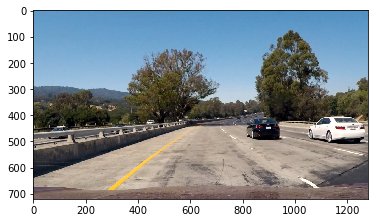

In [33]:
import glob
image_files = glob.glob('./test_images/*.jpg')
imgs_test = []
for img_file in image_files:
    imgs_test.append(mpimg.imread(img_file))

plt.imshow(imgs_test[0])

## Sliding Windows
In test images bounding boxes were drawn manually to identify reasonable bounding box sizes for the sliding window search: 

|  No. |  Image | Car | BB Width  | BB Height  |
|---|---|---|---|---|
|  1 |  test1 | white  | 223  |  113 |
|  2 |  test1 | white  | 223  |  113 |

In [21]:
# Duplicated from udacity lesson code
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [22]:
# Duplicated from udacity lesson code

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

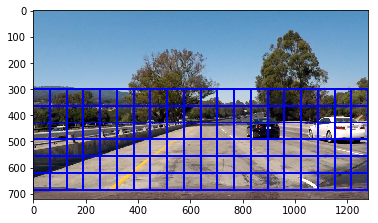

In [23]:
img_test = imgs_test[0]
windows = slide_window(img_test, x_start_stop=[None, None], y_start_stop=[300, 700], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(img_test, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
#cv2.imwrite("./output_images/windows.jpg", window_img)

## Search Vehicles in Windows

In [46]:
# Duplicated and adapted from udacity lesson code
def search_windows(img, windows, classifier, feature_extraction_params):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = features_for_image(test_img, feature_extraction_params)
        #5) Scale extracted features to be fed to classifier
        # TODO
        #test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = classifier.predict(features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [48]:
on_windows = search_windows(imgs_test[0], windows, svc, feature_extraction_params)

C:\bigdata\tools\anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\bigdata\tools\anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\bigdata\tools\anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  Deprecati